# Análise dos dados de CNPJ do Estado do Paraná

## Contexto:
No fim de 2019, a Receita Federal disponibilizou os dados abertos de todos os CNPJs, ativos e inativos. Os dados incluem todas as informações disponíveis no cartão CNPJ, o que permite diversas análises. Os dados foram disponibilizados em um formato proprietário e o pessoal do Observatório Social do Brasil - Município de Santo Antônio de Jesus - Estado da Bahia tratou e disponibizou esses dados em formatos mais legíveis. Você pode encontrar os dados e as ferramentas para tratativas no [repositório deles no GitHub](https://github.com/georgevbsantiago/qsacnpj). Ao descobrir esses dados e, principalmente, esse repositório, decidi realizar minhas próprias análises exploratórias nos dados, tentando, primeiramente, praticar minhas habilidades de análise e, consequentemente, obter insights sobre a realidade das empresas do Brasil.

## Objetivos:
### Gerais:
Esse repositório foi criado com o objetivo de ser um back-end que disponibiliza um endpoint REST contendo:
* As informações demográficas do Brasil (Estados, Mesorregiões, Microrregiões e Cidades);
* As informações de CNAEs (Seção, Divisão, Grupo, Classe e Subclasse);
* As informações das empresas do Estado do Paraná.

### Específicos:
* Entender o contexto atual das empresas do Estado do Paraná;
* Obter insights sobre mercados em expansão, mercados em retração, concentração de empresas de certos segmentos, entre outros;

## Limitações:
Como o volume de dados é absolutamente massivo, optei por trabalhar apenas com as empresas do Estado do Paraná, que estão ativas ou que fecharam a partir de 01/01/2016.


# Análise:

# Paraná:

O Estado do Paraná é o estado mais populoso da Região Sul e o 5º mais populoso do Brasil. Possui 399 cidades, 39 microrregiões e 10 mesorregiões. De acordo com a ultima atualização da RFB, em Novembro/2020, o estado possuía 1.527.870 empresas ativas.

In [8]:
# Import das libs gerais
from sqlalchemy import select, func
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import das libs locais
from utils.funcoes import consultaDados
from models.models import Cnpj, Cidade, Microrregiao, Mesorregiao, SituacaoCadastral, CnaeSecao, CnaeDivisao, CnaeGrupo, CnaeClasse, Cnae

In [18]:
def criaResumos(df, col, cols):
    return df[cols + [col]].pivot_table(values=cols, index=col, aggfunc='sum').reset_index().sort_values('Total', ascending=False).reset_index(drop=True)

def montaGraficos(df, rotulo, titulo, cols=['Ativa','Baixada'], rotation=45):
    img, ax = plt.subplots(figsize=(18,10))
    eixo_x = np.arange(len(df[rotulo]))
    cmap = plt.get_cmap('cividis')
    width = 0.35
    pos = - (width/2)
    for i, col in enumerate(cols):
        r = ax.bar(eixo_x + pos, df[col], width=width, label=col, color=cmap(i/len(cols)), bottom=0, ec='black',linewidth=1.2)
        label = df[col].apply(lambda x: '  {:,.0f}'.format(x).replace(',','.'))
        ax.bar_label(r, padding=5, labels=label, fontsize=14, rotation=90)
        pos = -pos 
    ax.set_title(titulo)
    ax.set_xticks(eixo_x)
    ax.set_xticklabels(df[rotulo])
    ax.yaxis.set_major_formatter(lambda x, p: '{:,.0f}'.format(x).replace(',','.'))
    ax.legend()
    plt.xticks(rotation=rotation)
    return img

In [3]:
# Monto a consulta
def getDadosDemograficos():
    dados = select(
        Cidade.nome.label("Cidade"),
        Cidade.ddd,
        Microrregiao.nome.label("Microrregião"),
        Mesorregiao.nome.label("Mesorregião"),
        SituacaoCadastral.descricao.label("Situação"),
        func.count(Cnpj.id).label('Qtde')) \
        .select_from(Cnpj) \
        .join(Cnpj.siafi) \
        .join(Cidade.meso) \
        .join(Cidade.micro)\
        .join(Cnpj.situacao_cadastral) \
        .group_by(
        Cidade.nome, Cidade.ddd,
        Mesorregiao.nome, Microrregiao.nome,
        SituacaoCadastral.descricao)

    # Consulto os dados no banco:
    dados = consultaDados(dados)
    # Vou usar as colunas com os valores muitas vezes, então vou criar uma variável com elas
    cols_qtdes = list(dados['Situação'].unique())
    # Faço uma tabela dinamica para agrupar os dados:
    dados = dados.pivot_table('Qtde', index=['Cidade', 'ddd', 'Microrregião', 'Mesorregião'], columns='Situação', aggfunc='sum').reset_index().fillna(0)
    # Crio a coluna de totais:
    dados['Total'] = dados[cols_qtdes].sum(axis=1)
    # Classifico as Cidades pelo total de empresas:
    dados = dados.sort_values('Total', ascending=False).reset_index(drop=True)
    # Removo o nome das colunas:
    dados.columns.name = None
  # Atualizo a cols_qtdes para incluir "Total"
    cols_qtdes.append('Total')

   # Converto os dados de float para int
    for col in cols_qtdes:
        dados[col] = dados[col].astype(int)

    return dados, cols_qtdes

dados_demograficos, cols_qtdes = getDadosDemograficos()

In [4]:
# Crio os Dataframes separadamente:
cidades = criaResumos(dados_demograficos, 'Cidade', cols_qtdes)
microrregioes = criaResumos(dados_demograficos, 'Microrregião', cols_qtdes)
mesorregioes = criaResumos(dados_demograficos, 'Mesorregião', cols_qtdes)
ddds = criaResumos(dados_demograficos, 'ddd', cols_qtdes)

In [6]:
#Faço as definições dos gráficos
plt.style.use('ggplot')
plt.rcParams["axes.labelsize"] = 18
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["font.size"] = 18

# Dados Demográficos: 
## Distribuição das empresas por faixa de DDD, Cidades, Microrregiões e Mesorregiões, agrupadas por Situação


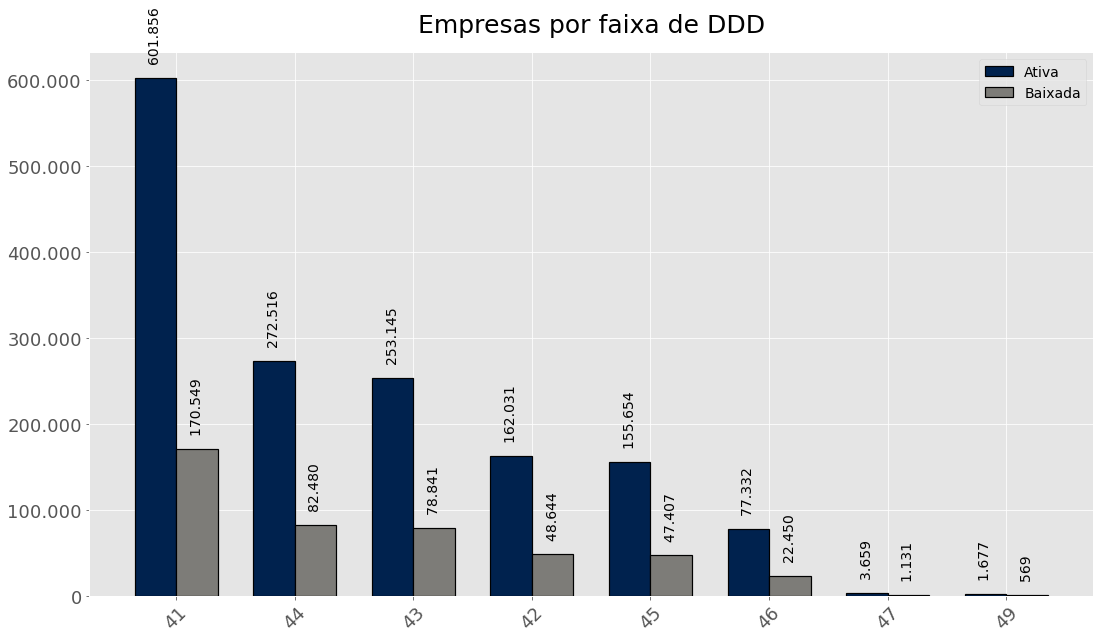

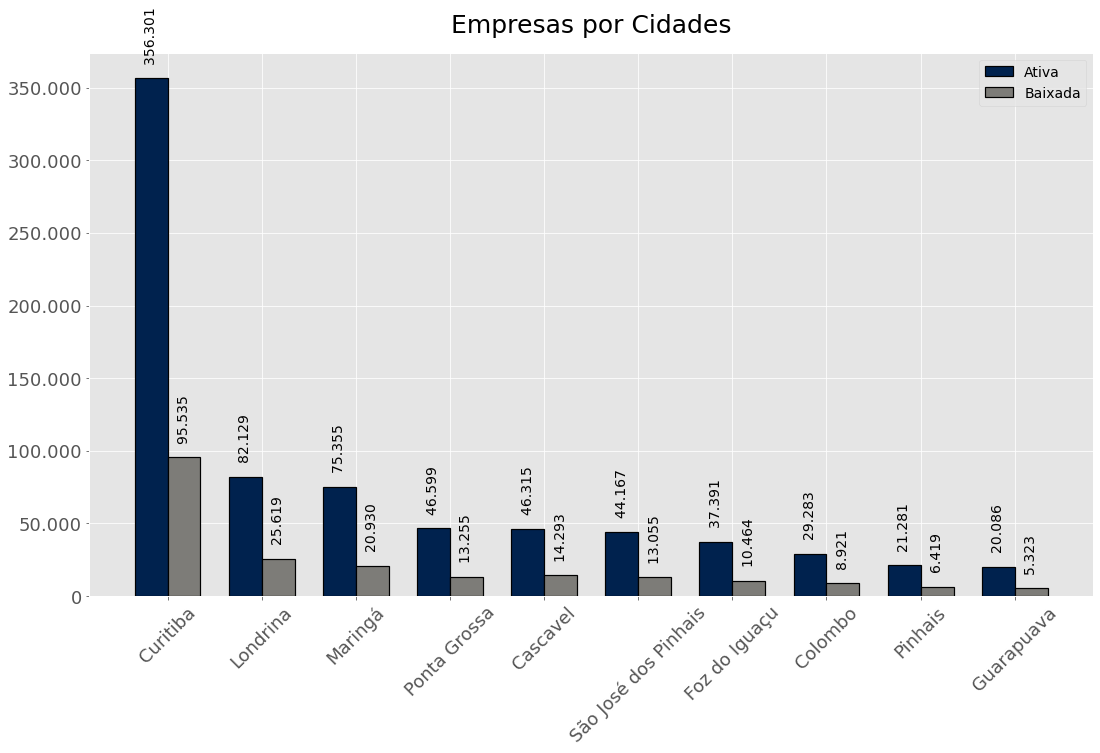

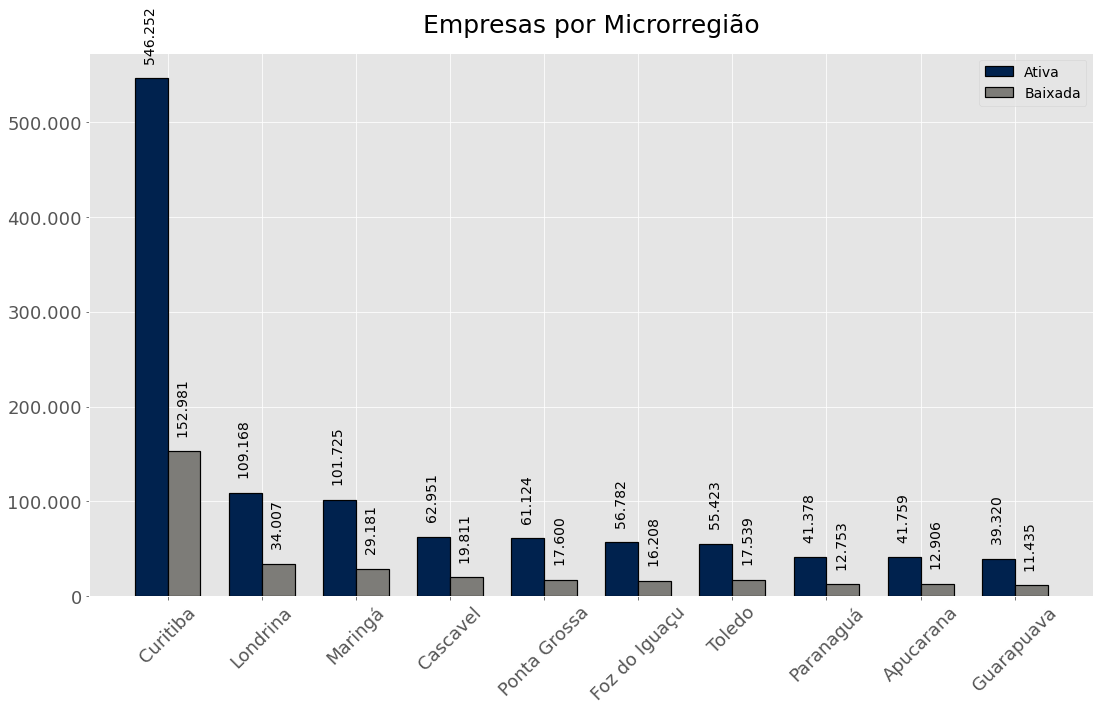

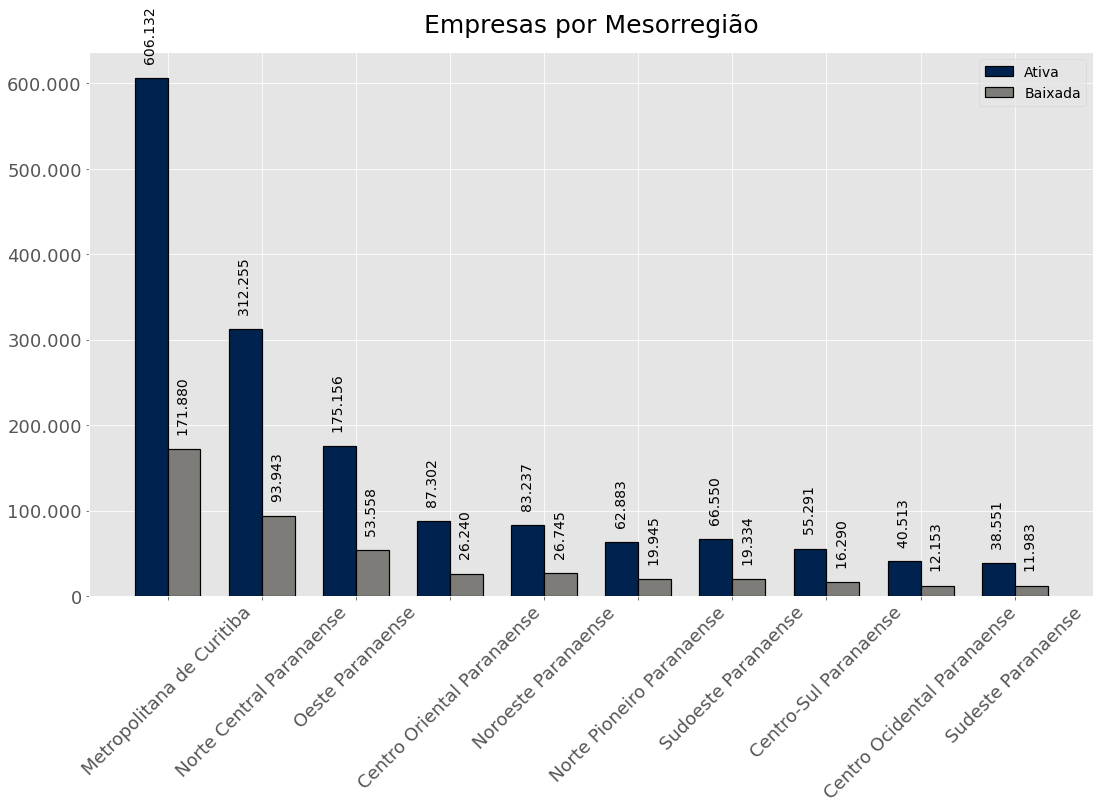

In [7]:
# Monto os gráficos:
ddd = montaGraficos(ddds,'ddd','Empresas por faixa de DDD')
cdds = montaGraficos(cidades.head(10),'Cidade','Empresas por Cidades')
micros = montaGraficos(microrregioes.head(10), 'Microrregião', 'Empresas por Microrregião')
mesos = montaGraficos(mesorregioes.head(10), 'Mesorregião','Empresas por Mesorregião')


# Distribuição por Seção de Atividade:

In [15]:
def getDadosCnaes():
    dados = select(
        CnaeSecao.descricao.label('Seção Cnae'),
        func.count(Cnpj.id).label('Qtde')
    ).select_from(Cnpj) \
        .join(Cnpj.cnae) \
        .join(Cnae.classe) \
        .join(CnaeClasse.grupo) \
        .join(CnaeGrupo.divisao) \
        .join(CnaeDivisao.secao) \
        .group_by('Seção Cnae')
    dados = consultaDados(dados)

    return dados.sort_values('Qtde', ascending=False)

dados_secao = getDadosCnaes()

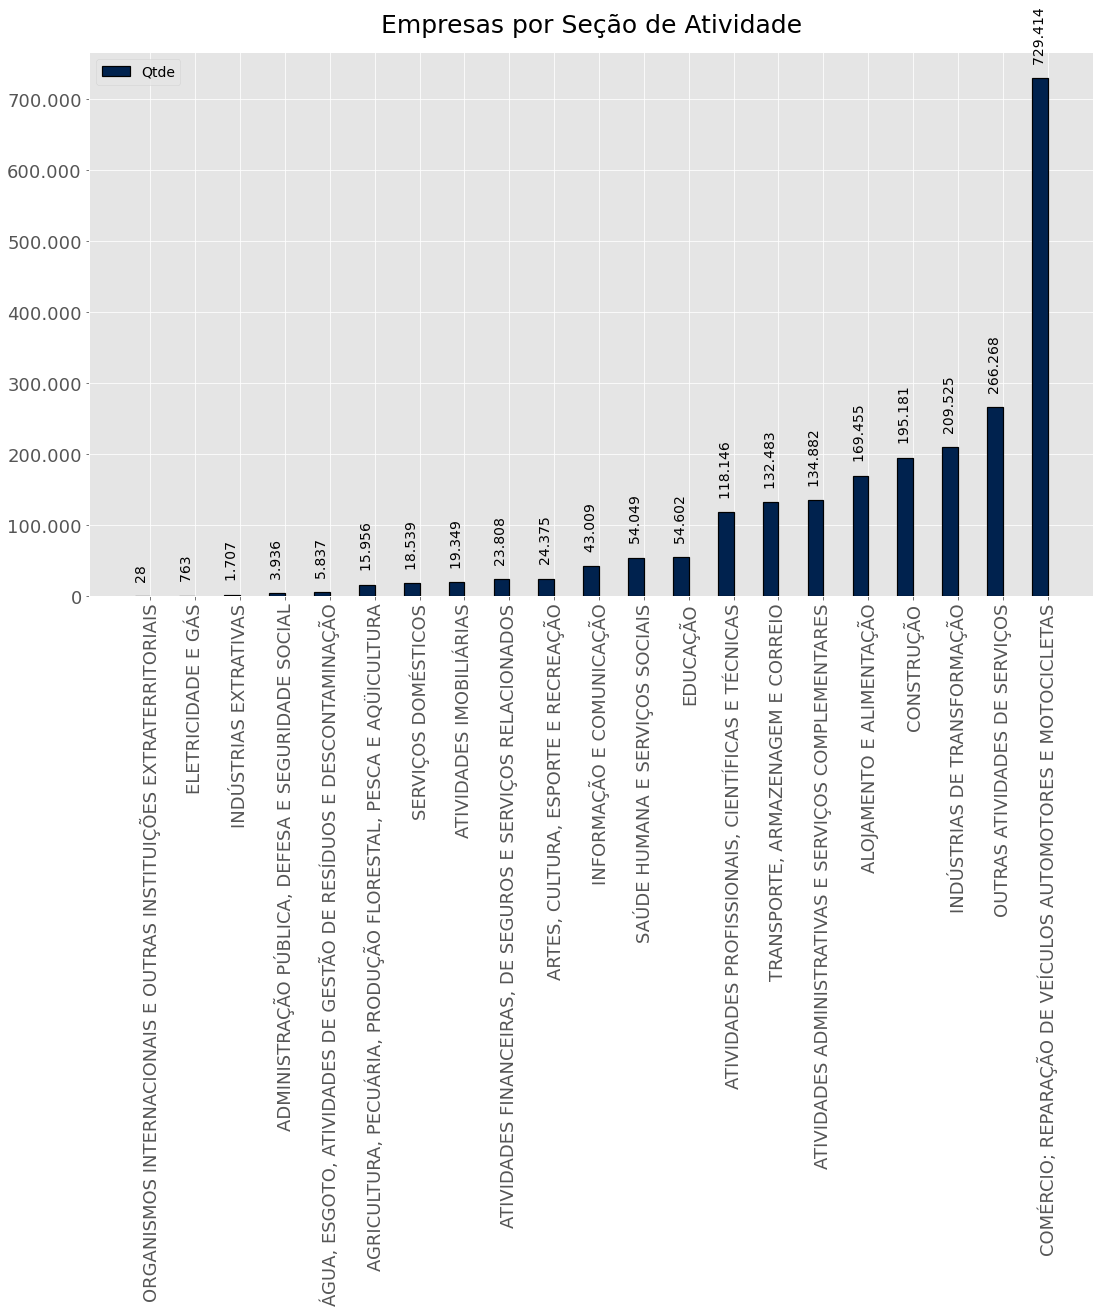

In [20]:
dados_secao
graf_secao = montaGraficos(dados_secao, "Seção Cnae", "Empresas por Seção de Atividade", ['Qtde'], rotation=90)